In [286]:
import dotenv
import os

dotenv.load_dotenv()
import matplotlib.pyplot as plt
%matplotlib inline

from typing import List, Tuple

import random
import numpy

In [287]:
from utils.frameReader import FrameReader
from utils.predictor import GVLPredictor
from utils.visualiser import GVLVisualizer
from utils.vlm import ClaudeVLM, OpenAIVLM, GeminiVLM

In [288]:
order = 'unshuffled'


# Teacher Example

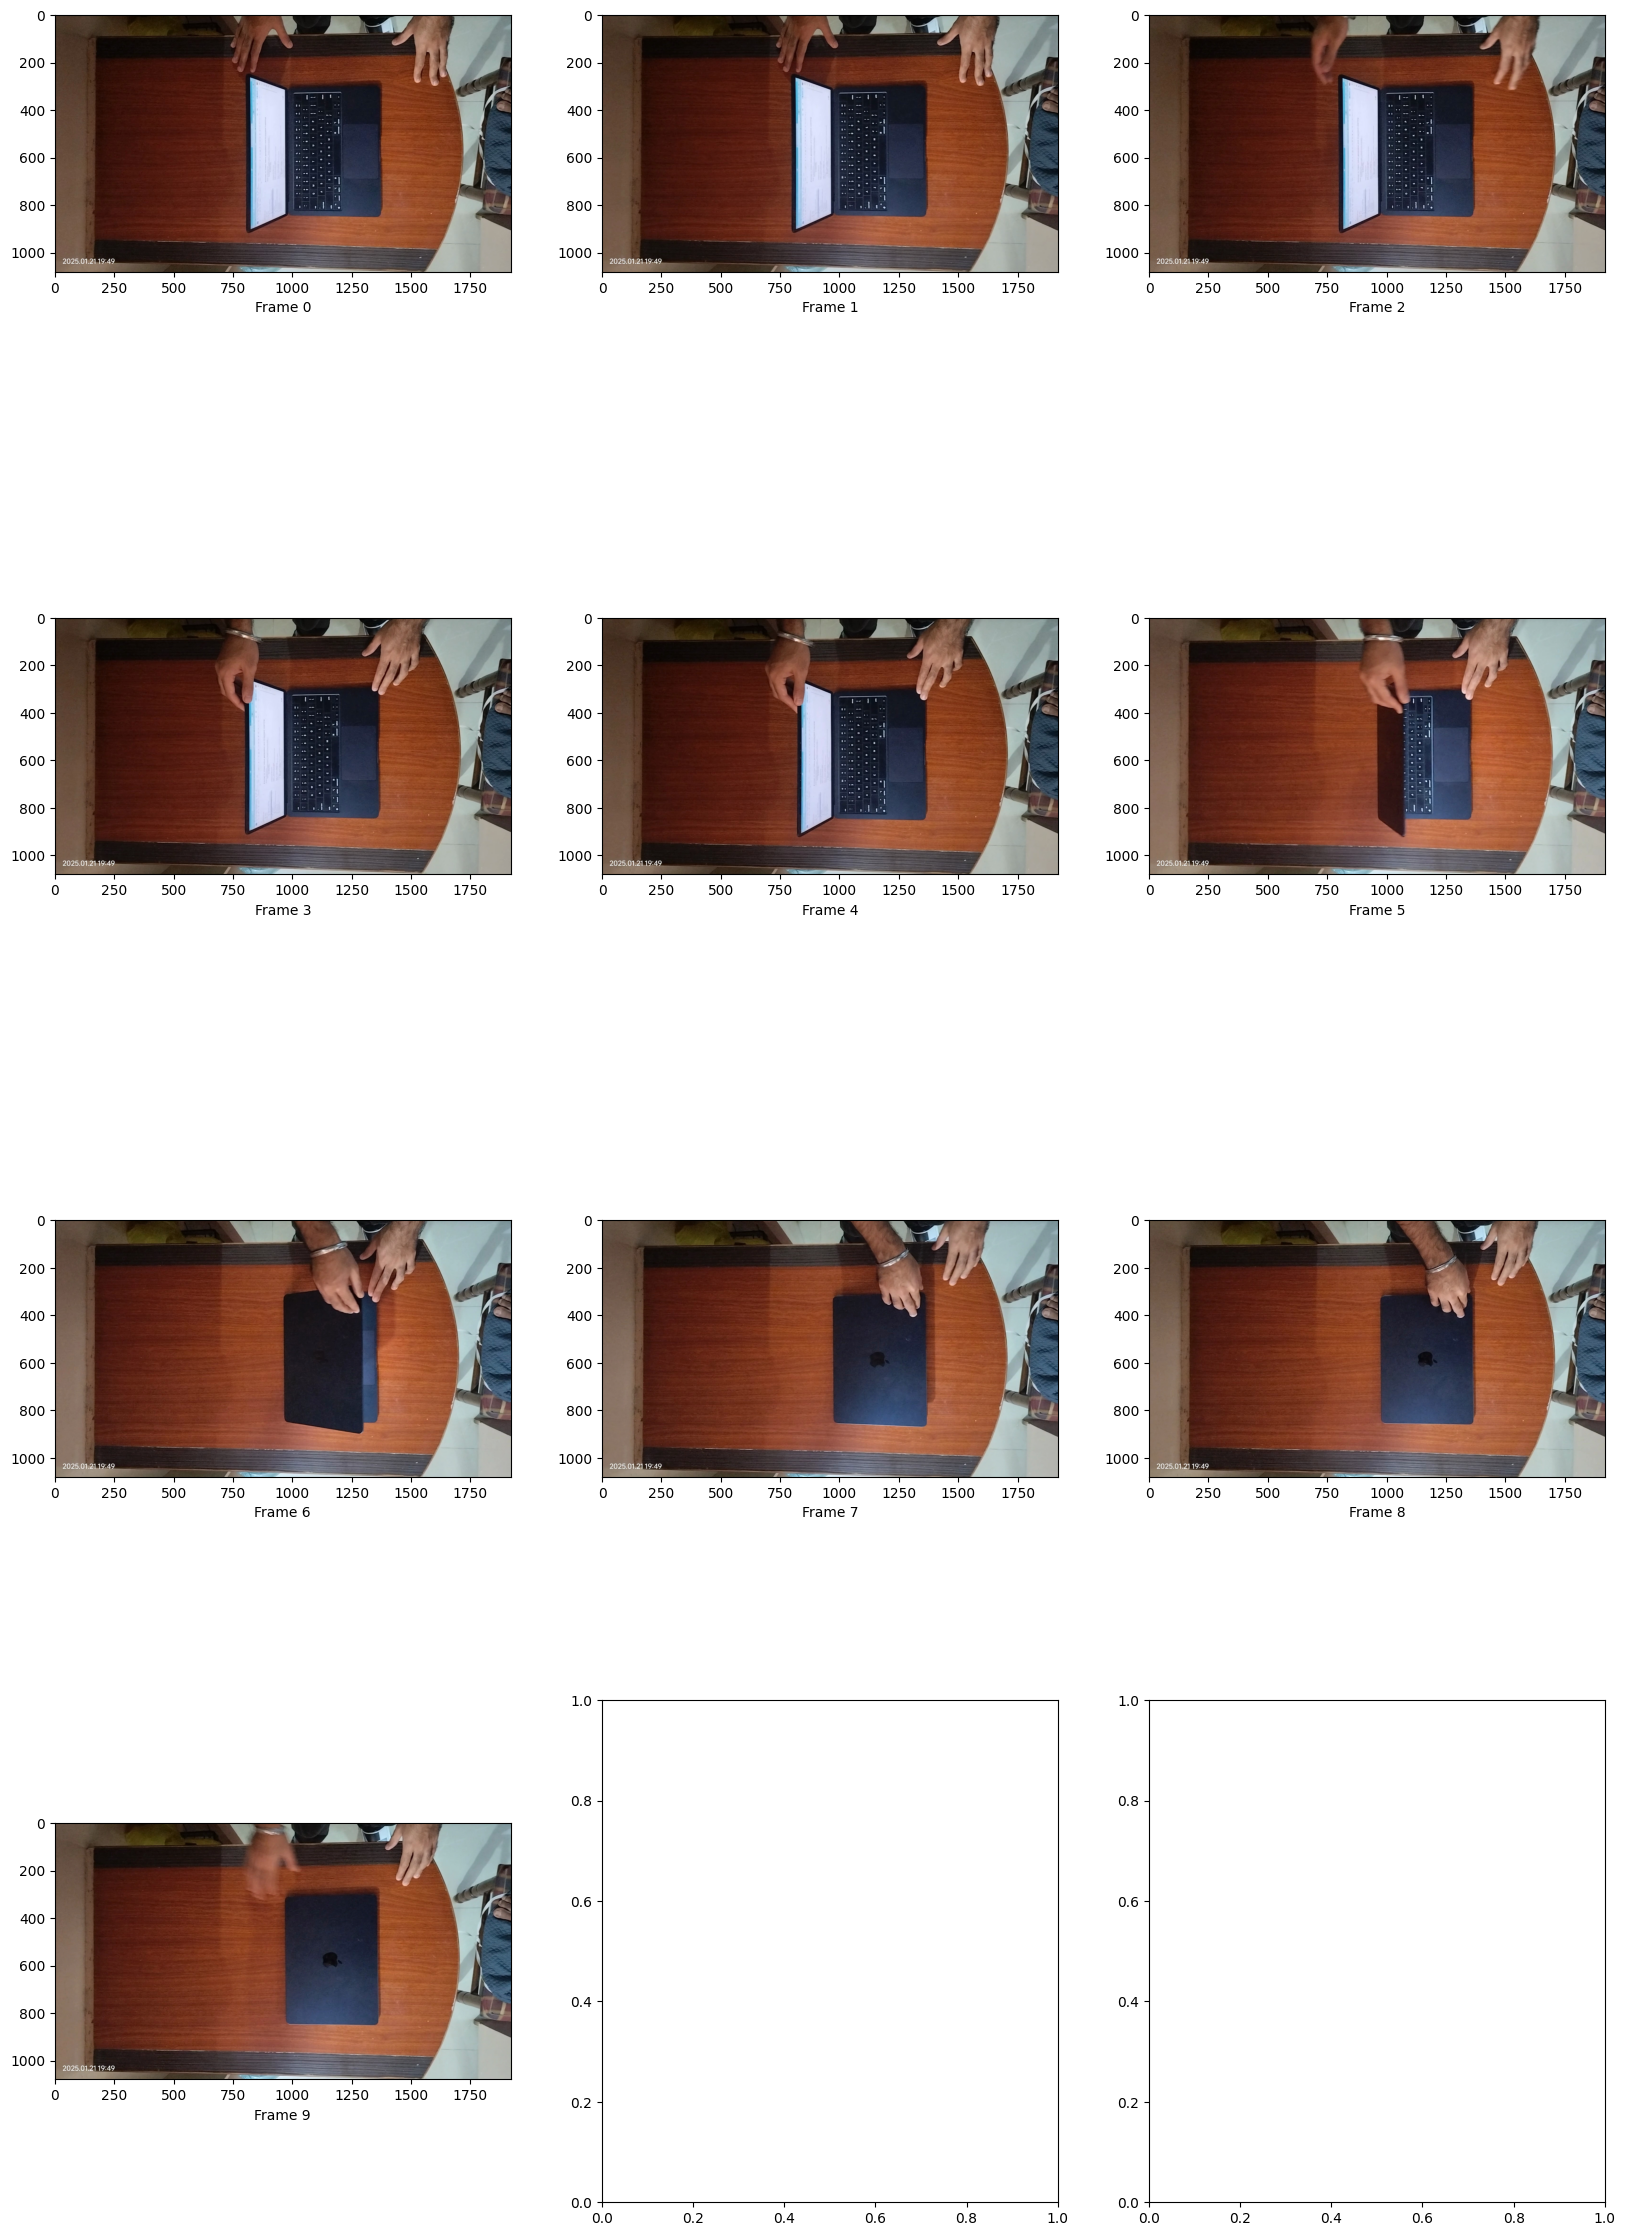

In [289]:
image_columns = 3

# Read frames
teacher_dir = "data/frames/laptop_success_1"
teacher_frames = FrameReader.read_frames_from_dir(teacher_dir)

num_frames = len(teacher_frames)
fig, ax = plt.subplots(num_frames//image_columns + 1, image_columns, figsize=(20, 30))
c = 0
for i, ix in enumerate(teacher_frames):
    ax[c//image_columns][c%image_columns].imshow(ix)
    #set x label
    ax[c//image_columns][c%image_columns].set_xlabel(f"Frame {i}")

    c+=1

# Inference video

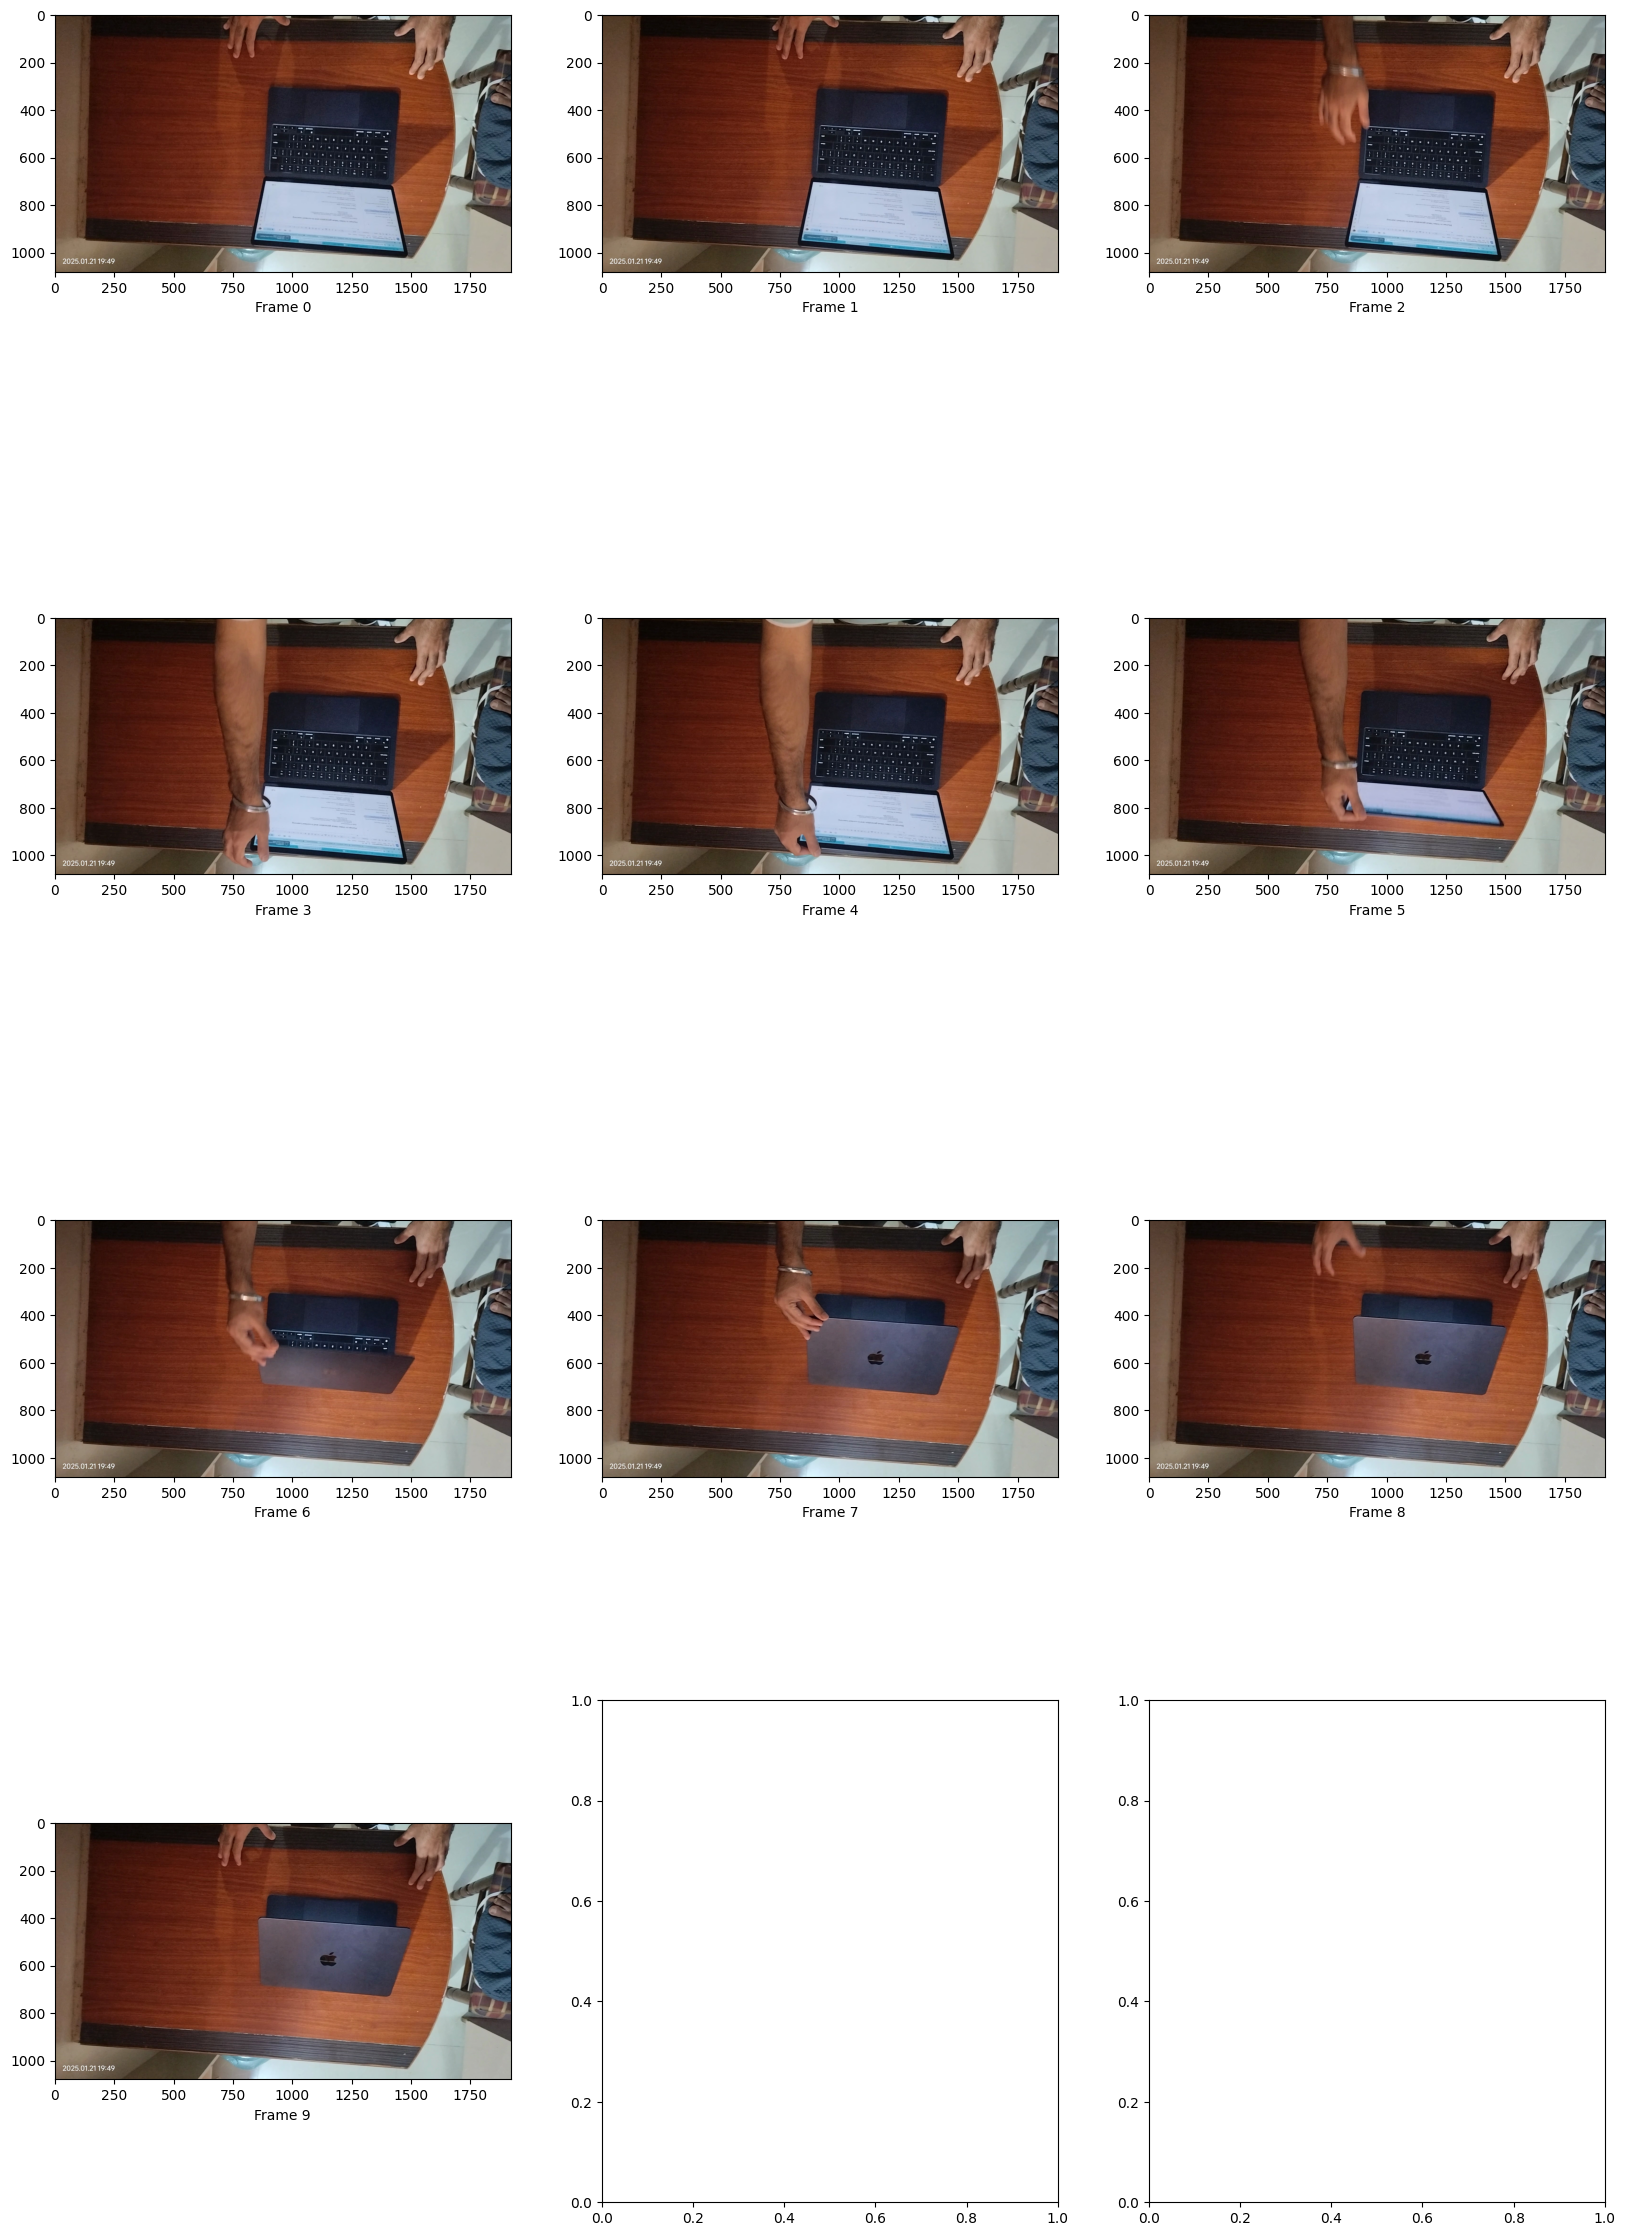

In [290]:
image_columns = 3

# Read frames
frames_dir = "data/frames/laptop_fail_1"
frames = FrameReader.read_frames_from_dir(frames_dir)

num_frames = len(frames)
fig, ax = plt.subplots(num_frames//image_columns + 1, image_columns, figsize=(20, 30))
c = 0
for i, ix in enumerate(frames):
    ax[c//image_columns][c%image_columns].imshow(ix)
    #set x label
    ax[c//image_columns][c%image_columns].set_xlabel(f"Frame {i}")

    c+=1

In [291]:
def shuffle_frames(
    frames: List, keep_first: bool = True
) -> Tuple[List, List]:
    """Shuffle frames while optionally keeping first frame fixed."""
    if keep_first:
        first_frame = frames[0]
        remaining_frames = frames[1:]
        shuffled_indices = list(range(1, len(frames)))
        random.shuffle(shuffled_indices)

        shuffled_frames = [first_frame] + [frames[i] for i in shuffled_indices]
        indices = [0] + shuffled_indices
    else:
        shuffled_indices = list(range(len(frames)))
        random.shuffle(shuffled_indices)
        shuffled_frames = [frames[i] for i in shuffled_indices]
        indices = shuffled_indices

    return shuffled_frames, indices

In [292]:
# shuffled_frames, indices = shuffle_frames(frames)
shuffled_frames = frames


In [293]:
# fig, ax = plt.subplots(num_frames//image_columns + 1, image_columns, figsize=(20, 30))
# c = 0
# for i, ix in enumerate(shuffled_frames):
#     ax[c//image_columns][c%image_columns].imshow(ix)
#     #set x label
#     ax[c//image_columns][c%image_columns].set_xlabel(f"Frame {i}")

#     c+=1

In [294]:
import io

In [295]:
import base64

import google.generativeai as genai
from IPython.display import Markdown
from PIL import Image

# Assuming you have the following:
# - list_pil_images: list of PIL images
# - list_base64_images: list of base64 encoded strings of the images
# - task_description: string describing the task

# Prepare the prompt with the task description
prompt_template_1 = """
You are an expert roboticist tasked to predict task completion percentages for frames of a robot for the task of {task_description}. You are given {num_frames} frames.
The task completion percentages are between 0 and 100, where 100 corresponds to full task completion. 
In the initial robot scene, the task completion percentage is 0.

For your reference, here is an example of a success scenario for the task of {task_description}:"""

prompt_template_2 = """
Now, for the task of '{task_description}', output the task completion percentage for the following frames. 
Compare each frame to the corrponding frame in the success scenario and provide the task completion percentage for each frame. 
Base your completion percentage based on task completion in comparison to the success scenario.
For each frame, format your response as follow: 
Frame [i]: Frame Description: [], Task Completion Percentages:[]%
Frame [1]: [IMG]
...
Frame [n]: [IMG]
"""


In [296]:
task_description = "close the laptop lid. the lid should be closed to completion."

In [297]:
def image_to_base64(image: Image.Image, format="JPEG") -> str:
    buffer = io.BytesIO()
    image.save(buffer, format=format)
    img_str = base64.b64encode(buffer.getvalue()).decode("utf-8")
    return img_str


In [298]:
correct_order = [i for i in range(len(frames))]

In [299]:
inference_base64 = [image_to_base64(Image.fromarray(numpy.array(ix))) for ix in shuffled_frames]
teacher_base64 = [image_to_base64(Image.fromarray(numpy.array(ix))) for ix in teacher_frames]

In [300]:
key = os.getenv("GEMINI_API_KEY")
genai.configure(api_key=key)
model = genai.GenerativeModel(model_name="gemini-2.0-flash-exp")


In [301]:
prompt_1 = prompt_template_1.format(task_description=task_description, num_frames=len(frames))
prompt_2 = prompt_template_2.format(task_description=task_description)

In [302]:
len(inference_base64), len(teacher_base64)

(10, 10)

In [303]:
# Prepare the list of images for the LLM
inference_images_for_llm = []
for base64_image in inference_base64:
    image_dict = {
        'mime_type': 'image/jpeg',  # Adjust MIME type if necessary
        'data': base64_image
    }
    inference_images_for_llm.append(image_dict)

teacher_images_for_llm = []
for base64_image in teacher_base64:
    image_dict = {
        'mime_type': 'image/jpeg',  # Adjust MIME type if necessary
        'data': base64_image
    }
    teacher_images_for_llm.append(image_dict)


print(f"sending {len(inference_images_for_llm)} images to the model")

# Generate content using the model
response = model.generate_content([prompt_1] + teacher_images_for_llm + [prompt_2] + inference_images_for_llm)

# Print the response
print(response.text)

sending 10 images to the model
Okay, I will assess the task completion percentages for each frame based on the provided success scenario and descriptions.

Frame 1:  Frame Description: [The laptop lid is fully open and the screen is facing up.], Task Completion Percentages:[0]%
Frame 2:  Frame Description: [The laptop lid is fully open and the screen is facing up.], Task Completion Percentages:[0]%
Frame 3:  Frame Description: [The robot hand is reaching towards the laptop's left corner], Task Completion Percentages:[10]%
Frame 4:  Frame Description: [The robot hand is starting to close the laptop at the left corner], Task Completion Percentages:[25]%
Frame 5:  Frame Description: [The robot hand is closing the laptop at the left corner], Task Completion Percentages:[30]%
Frame 6:  Frame Description: [The robot hand is in the middle of closing the laptop], Task Completion Percentages:[50]%
Frame 7:  Frame Description: [The laptop is almost closed], Task Completion Percentages:[75]%
Fram

In [304]:
import json

lines = response.text.strip().split('\n')

frames_output = []

for line in lines:
    if line.startswith('Frame '):
        # Extract frame number
        frame_no = int(line.split(':')[0].split(' ')[1])
        # Extract description
        description_start = line.find('Frame Description: [') + len('Frame Description: [')
        description_end = line.find('], Task Completion Percentages:')
        description = line[description_start:description_end]
        # Extract percentage
        percentage_start = line.find('Task Completion Percentages:[') + len('Task Completion Percentages:[')
        percentage_end = line.find(']%', percentage_start)
        percentage = int(line[percentage_start:percentage_end])
        # Create dictionary and append to list
        frame = {
            "frame_no": frame_no,
            "description": description,
            "percentage": percentage
        }
        frames_output.append(frame)

# Convert to JSON
json_output = json.dumps(frames_output, indent=4)
print(json_output)

[
    {
        "frame_no": 1,
        "description": "The laptop lid is fully open and the screen is facing up.",
        "percentage": 0
    },
    {
        "frame_no": 2,
        "description": "The laptop lid is fully open and the screen is facing up.",
        "percentage": 0
    },
    {
        "frame_no": 3,
        "description": "The robot hand is reaching towards the laptop's left corner",
        "percentage": 10
    },
    {
        "frame_no": 4,
        "description": "The robot hand is starting to close the laptop at the left corner",
        "percentage": 25
    },
    {
        "frame_no": 5,
        "description": "The robot hand is closing the laptop at the left corner",
        "percentage": 30
    },
    {
        "frame_no": 6,
        "description": "The robot hand is in the middle of closing the laptop",
        "percentage": 50
    },
    {
        "frame_no": 7,
        "description": "The laptop is almost closed",
        "percentage": 75
    },
    {
     

In [305]:
#lambda function for descriptions
#add \n after every nth character in description
add_newline = lambda x, n: '\n'.join([x[i:i+n] for i in range(0, len(x), n)])



In [306]:
indices = list(range(len(frames)))

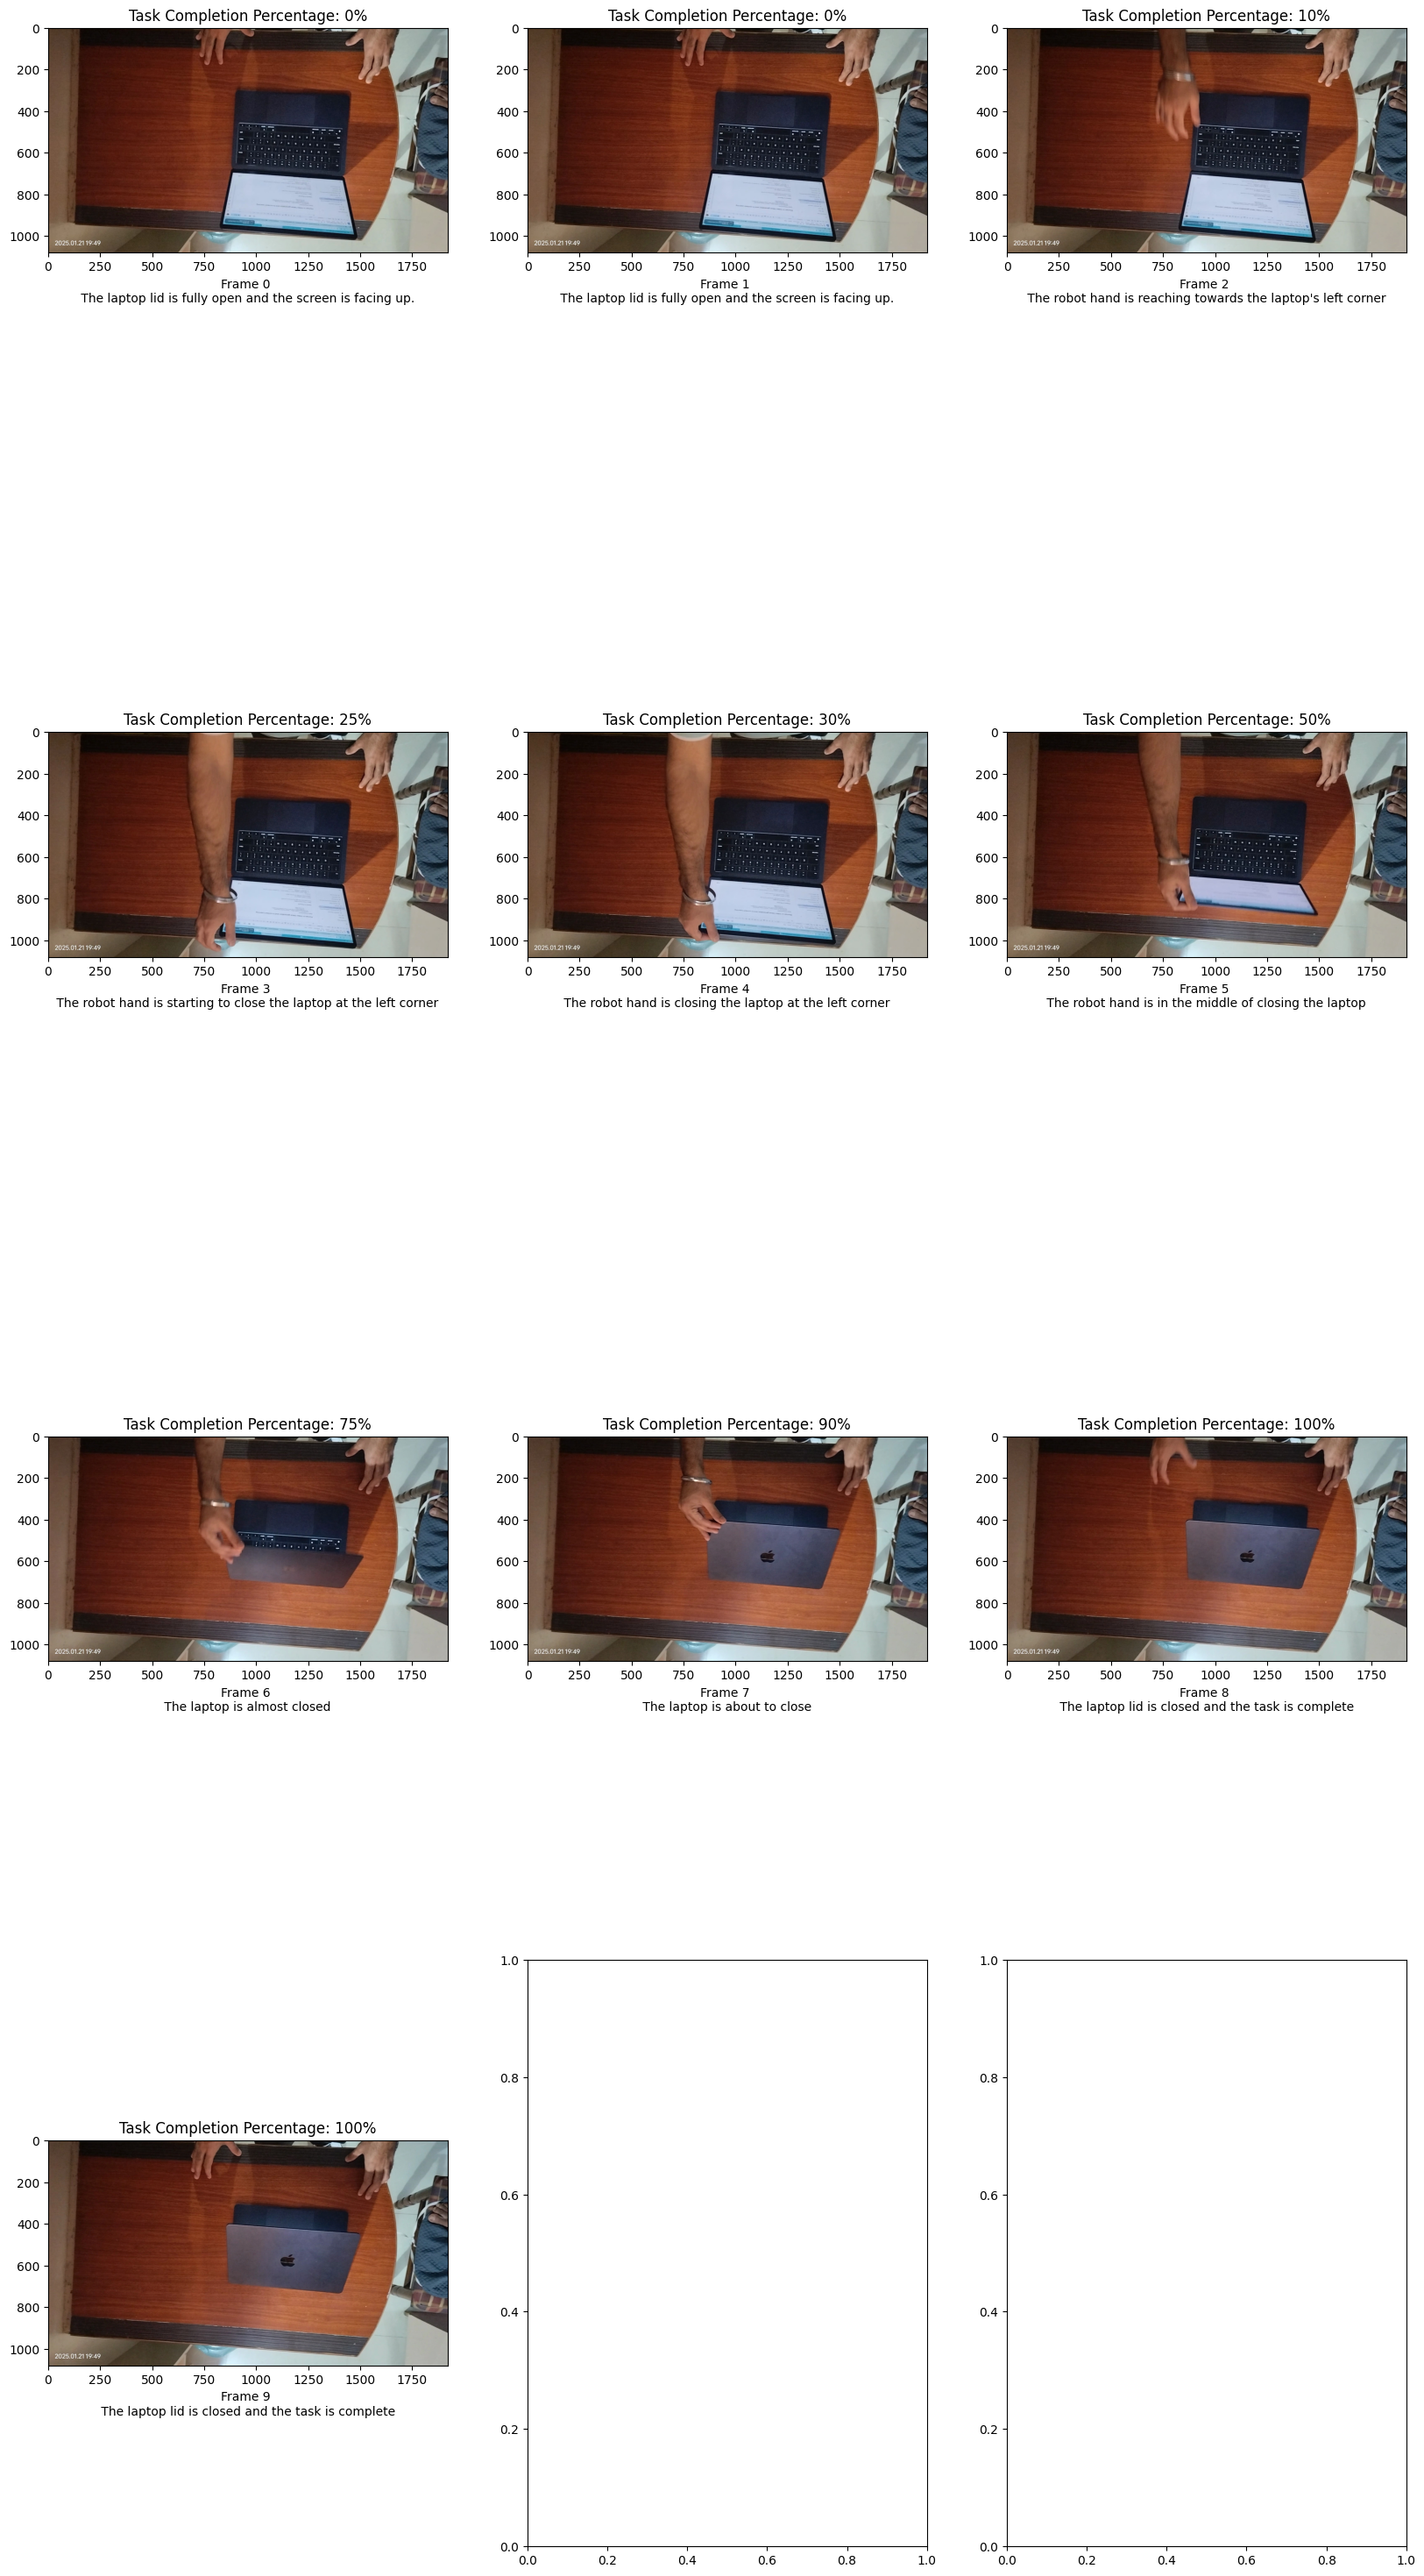

In [307]:
fig, ax = plt.subplots(num_frames//image_columns + 1, image_columns, figsize=(20, 40))
c = 0
for i, (image, indice, json_obj) in enumerate(zip(shuffled_frames, indices, frames_output)):
    ax[c//image_columns][c%image_columns].imshow(image)
    #set x label
    ax[c//image_columns][c%image_columns].set_xlabel(f"Frame {indice} \n {add_newline(json_obj['description'], 65)} \n")
    
    ax[c//image_columns][c%image_columns].title.set_text(f"Task Completion Percentage: {json_obj['percentage']}%")
    c+=1

In [308]:
import pandas as pd


df = pd.DataFrame(frames_output)
df['true_frame'] = indices if order == 'shuffled' else df['frame_no']
df

frame_no                                        description  percentage  \
0         1  The laptop lid is fully open and the screen is...           0   
1         2  The laptop lid is fully open and the screen is...           0   
2         3  The robot hand is reaching towards the laptop'...          10   
3         4  The robot hand is starting to close the laptop...          25   
4         5  The robot hand is closing the laptop at the le...          30   
5         6  The robot hand is in the middle of closing the...          50   
6         7                        The laptop is almost closed          75   
7         8                       The laptop is about to close          90   
8         9  The laptop lid is closed and the task is complete         100   
9        10  The laptop lid is closed and the task is complete         100   

   true_frame  
0           1  
1           2  
2           3  
3           4  
4           5  
5           6  
6           7  
7           8  
8           9  
9          10

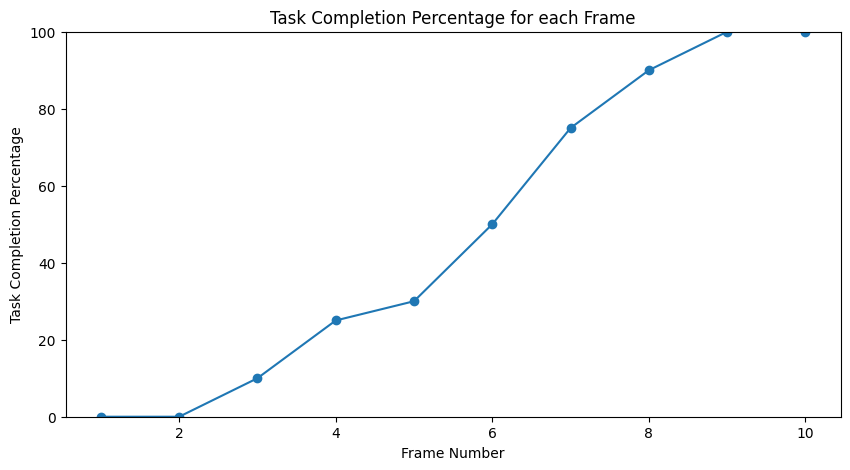

In [309]:
frame_percentage = [(row['true_frame'], row['percentage']) for index, row in df.iterrows()]
frame_percentage.sort(key=lambda x: x[0])

#create line plot with markers
plt.figure(figsize=(10, 5))
plt.plot([x[0] for x in frame_percentage], [x[1] for x in frame_percentage], marker='o')
plt.ylim(0, 100)
plt.xlabel('Frame Number')
plt.ylabel('Task Completion Percentage')
plt.title('Task Completion Percentage for each Frame')
plt.show()